In [1]:
# Main packages
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # plot handling

In [2]:
from tensorflow.keras.models import load_model

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
from keras import backend as K
from keras import activations, initializers, regularizers, constraints, metrics
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (Dense, Dropout, Activation, Flatten, Reshape, Layer,
                          BatchNormalization, LocallyConnected2D,
                          ZeroPadding2D, Conv2D, MaxPooling2D, Conv2DTranspose,
                          GaussianNoise, UpSampling2D, Input)
from keras.utils import conv_utils
from keras.layers import Lambda
from keras.engine import Layer, InputSpec

In [4]:
# Tensorflow-Keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Define parameters values
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42
PATH = "Cyclone_Wildfire_Flood_Earthquake_Database"
#Cyclone_Wildfire_Flood_Earthquake_Database
#Get train image with generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 4428 files belonging to 4 classes.
Using 3100 files for training.
Found 4428 files belonging to 4 classes.
Using 1328 files for validation.


In [6]:
# Get class names
classes = train_ds.class_names

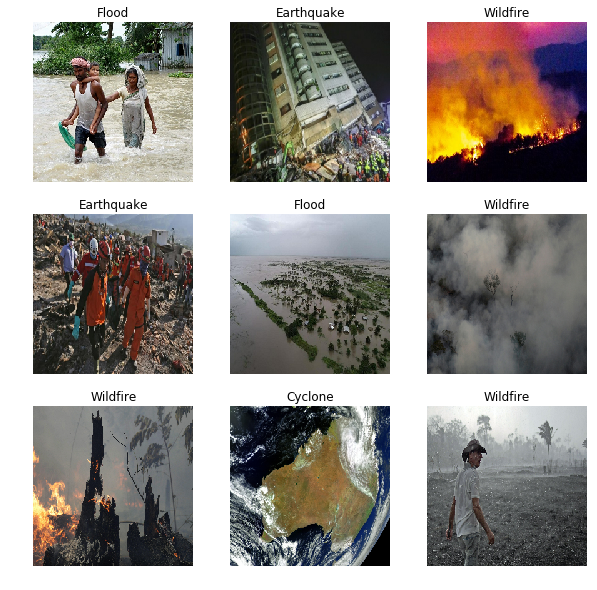

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")


In [93]:
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)])

In [94]:
# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [95]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [96]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


In [97]:
# Extend the hidden output if you want to see the model structure
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 3)  0           sequential_2[0][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 64) 1792        rescaling_2[0][0]                
____________________________________________________________________________________________

In [98]:
"""ok = True

if ok:
    # Parameters
    EPOCHS = 
    CALLBACK = [
        keras.callbacks.ModelCheckpoint("model.{epoch:02d}-{val_loss:.2f}.h5"),
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
    """
#else:
model = keras.models.load_model('model.01-0.53.h5')

In [99]:
# List all data in history
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [100]:
for items in history.history.items():
    print(items)

('loss', [0.8224276900291443, 0.6417069435119629, 0.5957425236701965, 0.5066760778427124, 0.5223698019981384])
('categorical_accuracy', [0.6903225779533386, 0.7664515972137451, 0.7841935753822327, 0.8058064579963684, 0.8119354844093323])
('val_loss', [1.7504339218139648, 2.7565104961395264, 3.464587450027466, 3.9804158210754395, 3.6512296199798584])
('val_categorical_accuracy', [0.2439759075641632, 0.2439759075641632, 0.2439759075641632, 0.2439759075641632, 0.2469879537820816])


In [101]:
print(list(sorted(history.history.items())))

[('categorical_accuracy', [0.6903225779533386, 0.7664515972137451, 0.7841935753822327, 0.8058064579963684, 0.8119354844093323]), ('loss', [0.8224276900291443, 0.6417069435119629, 0.5957425236701965, 0.5066760778427124, 0.5223698019981384]), ('val_categorical_accuracy', [0.2439759075641632, 0.2439759075641632, 0.2439759075641632, 0.2439759075641632, 0.2469879537820816]), ('val_loss', [1.7504339218139648, 2.7565104961395264, 3.464587450027466, 3.9804158210754395, 3.6512296199798584])]


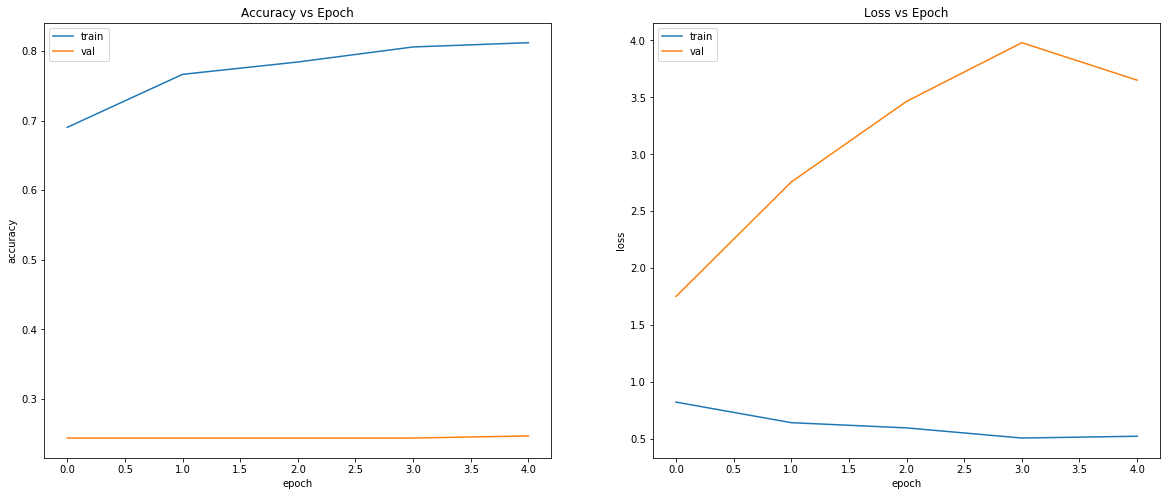

In [102]:
# Create a plot layout
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Summarize history for accuracy
ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Accuracy vs Epoch')
ax[0].set(xlabel='epoch', ylabel='accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

# Summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# Display plots
plt.show()

In [23]:
imgs = [
    "cyclone.jpg",
    "earthquake.jpg",
    "flood.jpg"
]
for img in imgs:
    try:
        # Load the image
        raw_img = keras.preprocessing.image.load_img(img, target_size=IMG_SIZE)
    except:
        continue
    
    # Conver to to numpy array
    img_array = keras.preprocessing.image.img_to_array(raw_img)
    
    # Reshaping
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    # Make predictions
    predictions = model.predict(img_array)
    series      = pd.Series(predictions[0], index=classes)
    
    # Get score
    proba      = np.max(predictions)
    pred_class = classes[np.argmax(predictions)]
    
    # Display results
    #fig, ax = plt.subplots(1, 2, figsize=(24, 4))
    
    #ax[0].imshow(raw_img)
    #ax[0].title.set_text(f"This image may be {pred_class} at {round(proba * 100,2)}%")
    #print(pred_class," at ",{round(proba * 100,2)},"%")
    print(pred_class," at ", round(proba * 100,2),"%")

Cyclone  at  99.98 %
Earthquake  at  98.67 %
Flood  at  99.85 %


In [22]:
type(pred_class)

str

In [114]:
raw_img = keras.preprocessing.image.load_img("earthquake.jpg", target_size=IMG_SIZE)
   
    
    # Conver to to numpy array
img_array = keras.preprocessing.image.img_to_array(raw_img)
    
    # Reshaping
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    # Make predictions
predictions = model.predict(img_array)

In [115]:
predictions[0][0] 

0.00797071

In [116]:
predictions[0]

array([7.9707103e-03, 9.8666245e-01, 5.2222447e-03, 1.4451609e-04],
      dtype=float32)

In [117]:
predictions

array([[7.9707103e-03, 9.8666245e-01, 5.2222447e-03, 1.4451609e-04]],
      dtype=float32)

In [118]:
for i in range(1)

'Cyclone'